## Homework - module 1 - EDA Analysis

In [1]:
import pandas as pd
import warnings

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction import DictVectorizer

In [ ]:
warnings.filterwarnings("ignore")

path_to_january_data = "./data/fhv_tripdata_2021-01.parquet"
path_to_february_data = "./data/fhv_tripdata_2021-02.parquet"

## Q1 - Downloading Data 

In [2]:
df_january = pd.read_parquet(path_to_january_data, engine='pyarrow')
print(df_january.shape)
df_january.head()

(1154112, 7)


### Compute duration 

In [4]:
df_january["duration"] = df_january.dropOff_datetime - df_january.pickup_datetime
df_january["duration"] = df_january["duration"].apply( lambda x: x.total_seconds() / 60)
print("average trip duration:", df_january["duration"].mean()) 

average trip duration: 19.167224093791006


## Data preparation

In [5]:
df_january["duration"].describe()

count    1.154112e+06
mean     1.916722e+01
std      3.986922e+02
min      1.666667e-02
25%      7.766667e+00
50%      1.340000e+01
75%      2.228333e+01
max      4.233710e+05
Name: duration, dtype: float64

In [6]:
df_january["duration"].describe(percentiles=[.95, .98, .99])

count    1.154112e+06
mean     1.916722e+01
std      3.986922e+02
min      1.666667e-02
50%      1.340000e+01
95%      4.725000e+01
98%      6.613333e+01
99%      9.030000e+01
max      4.233710e+05
Name: duration, dtype: float64

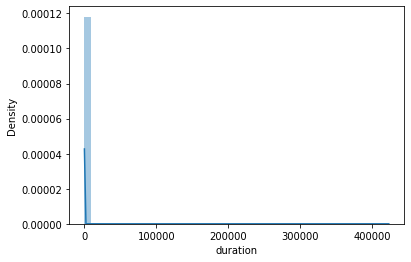

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.distplot(df_january["duration"], label='duration')
plt.show()

### Filter based on duration :: in (1, 60 min) 

In [8]:
((df_january["duration"]>=1 ) & (df_january["duration"]<=60 )).mean()

0.9616276409915155

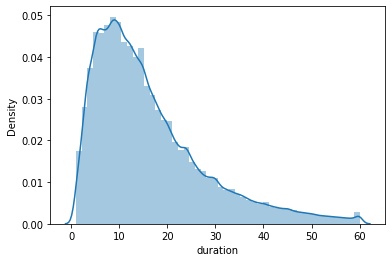

filtered_df_january shape (1109826, 8)


In [9]:
filtered_df_january = df_january[((df_january["duration"]>=1 ) & (df_january["duration"]<=60 ))]

sns.distplot(filtered_df_january["duration"], label='duration')
plt.show()
print("filtered_df_january shape", filtered_df_january.shape)

In [10]:
print (f"we removed around {100 * (1 - (1109826 / 1154112)):.2f} % of the initial data ")

we removed around 3.84 % of the initial data 


## Q3 Missing Values 

In [11]:
filtered_df_january.isnull().sum()

dispatching_base_num            0
pickup_datetime                 0
dropOff_datetime                0
PUlocationID               927008
DOlocationID               147907
SR_Flag                   1109826
Affiliated_base_number        773
duration                        0
dtype: int64

In [12]:
filtered_df_january.shape

(1109826, 8)

In [13]:
filtered_df_january[["PUlocationID", "DOlocationID"]] = filtered_df_january[["PUlocationID", "DOlocationID"]].fillna(-1)
filtered_df_january.head()

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number,duration
0,B00009,2021-01-01 00:27:00,2021-01-01 00:44:00,-1.0,-1.0,None,B00009,17.000000
1,B00009,2021-01-01 00:50:00,2021-01-01 01:07:00,-1.0,-1.0,None,B00009,17.000000
3,B00037,2021-01-01 00:13:09,2021-01-01 00:21:26,-1.0,72.0,None,B00037,8.283333
4,B00037,2021-01-01 00:38:31,2021-01-01 00:53:44,-1.0,61.0,None,B00037,15.216667
5,B00037,2021-01-01 00:59:02,2021-01-01 01:08:05,-1.0,71.0,None,B00037,9.050000


In [14]:
print(f"fraction of missing values in pickup location id is : {(927008 /1109826) *100 :.3f}%")

fraction of missing values in pickup location id is : 83.527%


## Q4 One Hot encoding

In [17]:
catgorical_columns = ["PUlocationID", "DOlocationID"]
train_dicts = filtered_df_january[catgorical_columns].to_dict(orient="records")

In [18]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [19]:
X_train.shape

(1109826, 2)

## Q5 One Hot encoding

In [20]:
target = "duration"
y_train = filtered_df_january[target].values
y_train

array([17.        , 17.        ,  8.28333333, ..., 16.2       ,
       19.43333333, 36.        ])

In [22]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

### Display target distribution 

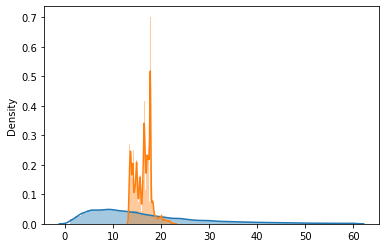

In [33]:
sns.distplot(y_train, label='ground_truth')
sns.distplot(y_pred, label='predictions')
plt.show()

### Measure RMSE on train data 

In [56]:
mean_squared_error(y_train, y_pred, squared=False)

11.415432830521663

## Q6 - Evaluating a model on validation set - February 

In [79]:
def get_data(path_to_data:str)->pd.DataFrame:
    catgorical_columns = ["PUlocationID", "DOlocationID"]
    df = pd.read_parquet(path_to_data, engine='pyarrow')
    df.pickup_datetime = pd.to_datetime(df.pickup_datetime)
    df.dropOff_datetime = pd.to_datetime(df.dropOff_datetime)
    df["duration"] = df.dropOff_datetime - df.pickup_datetime
    df["duration"] = df["duration"].apply( lambda x: x.total_seconds() / 60)

    print("average trip duration:", df["duration"].mean()) 
    df[catgorical_columns] = df[catgorical_columns].astype(str)
    df_filtered = df[((df["duration"]>=1 ) & (df["duration"]<=60 ))]
    
    
    df_filtered[catgorical_columns] = df_filtered[catgorical_columns].fillna(-1)
    
    return  df_filtered


In [80]:
df_train = get_data(path_to_data=path_to_january_data)
df_train.shape

average trip duration: 19.167224093791006


(1109826, 8)

In [81]:
dv = DictVectorizer()
lr = LinearRegression()

In [82]:
data_dicts = df_train[catgorical_columns].to_dict(orient="records")
X_train = dv.fit_transform(data_dicts)
y_train = df_train[target].values

In [83]:
X_train.shape

(1109826, 525)

In [84]:
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)
mean_squared_error(y_train, y_pred, squared=False)

10.528519107205623

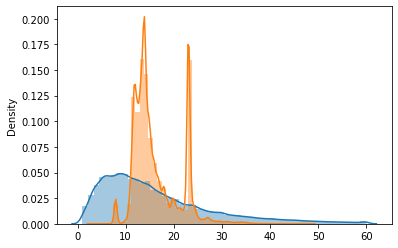

In [89]:
sns.distplot(y_train, label='ground_truth')
sns.distplot(y_pred, label='predictions')
plt.show()


### Validation dataset

In [85]:
df_validation = get_data(path_to_data=path_to_february_data)
df_validation.shape

average trip duration: 20.706986225199763


(990113, 8)

In [86]:
data_dicts = df_validation[catgorical_columns].to_dict(orient="records")
X_val = dv.transform(data_dicts)
y_val = df_validation[target].values

In [87]:
y_pred_val = lr.predict(X_val)
mean_squared_error(y_pred_val, y_val, squared=False)

11.014283143215204

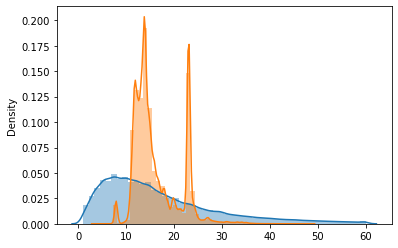

In [88]:
sns.distplot(y_val, label='ground_truth')
sns.distplot(y_pred_val, label='predictions')
plt.show()